In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
file = "kubernetes_resource_allocation_dataset.csv"
df = pd.read_csv(file)

# Display basic information about the dataset
print("Dataset Info:")
df.info()

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Selecting relevant columns (CPU, memory usage, requests, limits, pod status, restart count)
columns_to_keep = ['cpu_usage', 'memory_usage', 'cpu_request', 'cpu_limit', 'memory_request', 'memory_limit', 'pod_status', 'restart_count']
df_filtered = df[[col for col in columns_to_keep if col in df.columns]].copy()

# Separate numerical and categorical columns
numerical_cols = df_filtered.select_dtypes(include=['number']).columns
categorical_cols = df_filtered.select_dtypes(exclude=['number']).columns
print(categorical_cols)
# Handling missing values (Fill numerical with median, categorical with mode)
df_filtered[numerical_cols] = df_filtered[numerical_cols].fillna(df_filtered[numerical_cols].median())
for col in categorical_cols:
    df_filtered[col] = df_filtered[col].fillna(df_filtered[col].mode()[0])


# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_filtered[col] = le.fit_transform(df_filtered[col])
    label_encoders[col] = le

# Feature Engineering - Adding utilization rates
if 'cpu_usage' in df_filtered.columns and 'cpu_limit' in df_filtered.columns:
    df_filtered['cpu_utilization'] = df_filtered['cpu_usage'] / df_filtered['cpu_limit']
if 'memory_usage' in df_filtered.columns and 'memory_limit' in df_filtered.columns:
    df_filtered['memory_utilization'] = df_filtered['memory_usage'] / df_filtered['memory_limit']

# Adding moving averages
if 'cpu_usage' in df_filtered.columns:
    df_filtered['cpu_usage_ma'] = df_filtered['cpu_usage'].rolling(window=5).mean()
if 'memory_usage' in df_filtered.columns:
    df_filtered['memory_usage_ma'] = df_filtered['memory_usage'].rolling(window=5).mean()

# Labeling anomalies (example threshold-based approach)
if 'cpu_utilization' in df_filtered.columns:
    thresh_cpu = df_filtered['cpu_utilization'].quantile(0.95)  # 95th percentile
    df_filtered['cpu_anomaly'] = (df_filtered['cpu_utilization'] > thresh_cpu).astype(int)
if 'memory_utilization' in df_filtered.columns:
    thresh_memory = df_filtered['memory_utilization'].quantile(0.95)
    df_filtered['memory_anomaly'] = (df_filtered['memory_utilization'] > thresh_memory).astype(int)

# Splitting the dataset into train and test sets
features = [col for col in ['cpu_usage', 'memory_usage', 'cpu_request', 'cpu_limit', 'memory_request', 'memory_limit', 'cpu_utilization', 'memory_utilization', 'cpu_usage_ma', 'memory_usage_ma', 'pod_status'] if col in df_filtered.columns]
X = df_filtered[features]
y = df_filtered[['cpu_anomaly', 'memory_anomaly']].dropna(axis=1, how='all')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pod_name                 15000 non-null  object 
 1   namespace                15000 non-null  object 
 2   cpu_request              15000 non-null  float64
 3   cpu_limit                15000 non-null  float64
 4   memory_request           15000 non-null  float64
 5   memory_limit             15000 non-null  float64
 6   cpu_usage                15000 non-null  float64
 7   memory_usage             15000 non-null  float64
 8   node_name                15000 non-null  object 
 9   pod_status               15000 non-null  object 
 10  restart_count            15000 non-null  int64  
 11  uptime_seconds           15000 non-null  int64  
 12  deployment_strategy      15000 non-null  object 
 13  scaling_policy           15000 non-null  object 
 14  network_

In [10]:
# Save processed data including target labels
processed_file = "k8s_preprocessed_data.csv"
df_filtered.to_csv(processed_file, index=False)

print("Data preprocessing completed. Preprocessed data saved at:", processed_file)


Data preprocessing completed. Preprocessed data saved at: k8s_preprocessed_data.csv


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Load preprocessed data
processed_file = "k8s_preprocessed_data.csv"
df_processed = pd.read_csv(processed_file)

# Ensure target variables exist
target_cols = ['cpu_anomaly', 'memory_anomaly']
if not all(col in df_processed.columns for col in target_cols):
    raise ValueError(f"Target columns {target_cols} are missing in the preprocessed dataset!")

# Split features and target
X = df_processed.drop(columns=target_cols)
y = df_processed[target_cols]

# Check class distribution
print("CPU Anomaly Distribution:\n", y['cpu_anomaly'].value_counts())
print("\nMemory Anomaly Distribution:\n", y['memory_anomaly'].value_counts())

# Step 1: Handle missing values in features (X)
imputer = SimpleImputer(strategy="mean")  
X_filled = imputer.fit_transform(X)  # Filling NaN values

# Step 2: Apply SMOTE independently for CPU and Memory anomalies
smote = SMOTE(random_state=42)

X_resampled_cpu, y_cpu_resampled = smote.fit_resample(X_filled, y['cpu_anomaly'])
X_resampled_memory, y_memory_resampled = smote.fit_resample(X_filled, y['memory_anomaly'])

# Step 3: Ensure both targets have the same number of samples
max_samples = max(len(y_cpu_resampled), len(y_memory_resampled))

# Resample the smaller dataset again to match the larger one
if len(y_cpu_resampled) < max_samples:
    X_resampled_cpu, y_cpu_resampled = smote.fit_resample(X_resampled_cpu, y_cpu_resampled)

if len(y_memory_resampled) < max_samples:
    X_resampled_memory, y_memory_resampled = smote.fit_resample(X_resampled_memory, y_memory_resampled)

# Choose the larger X dataset
X_resampled = X_resampled_cpu if len(X_resampled_cpu) > len(X_resampled_memory) else X_resampled_memory

# Convert target back to DataFrame
y_resampled = pd.DataFrame({'cpu_anomaly': y_cpu_resampled, 'memory_anomaly': y_memory_resampled})

# Step 4: Train-test split (Only Once!)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Missing values handled and data resampling completed!")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Train an XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)


CPU Anomaly Distribution:
 cpu_anomaly
0    14250
1      750
Name: count, dtype: int64

Memory Anomaly Distribution:
 memory_anomaly
0    14250
1      750
Name: count, dtype: int64
Missing values handled and data resampling completed!


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [26]:

# Model Evaluation
rf_pred = rf_model.predict(X_test_scaled)
xgb_pred = xgb_model.predict(X_test_scaled)

print("Random Forest Performance:")
print(classification_report(y_test, rf_pred, zero_division=1))

print("\nXGBoost Performance:")
print(classification_report(y_test, xgb_pred, zero_division=1))

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2819
           1       1.00      1.00      1.00      2837

   micro avg       0.98      1.00      0.99      5656
   macro avg       0.98      1.00      0.99      5656
weighted avg       0.98      1.00      0.99      5656
 samples avg       0.99      1.00      0.99      5656


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2819
           1       1.00      1.00      1.00      2837

   micro avg       0.98      0.99      0.99      5656
   macro avg       0.98      0.99      0.99      5656
weighted avg       0.98      0.99      0.99      5656
 samples avg       0.99      1.00      0.99      5656



In [27]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), param_grid, cv=3, scoring='f1_weighted')
grid_search.fit(X_train_scaled, y_train)
best_xgb = grid_search.best_estimator_


In [14]:
# Save the best model
best_model = rf_model if accuracy_score(y_test, rf_pred) > accuracy_score(y_test, xgb_pred) else xgb_model
model_name = "random_forest" if best_model == rf_model else "xgboost"

joblib.dump(best_model, f"k8s_best_model_{model_name}.pkl")

print(f"\nBest Model: {model_name} saved as 'k8s_best_model_{model_name}.pkl'")


Best Model: random_forest saved as 'k8s_best_model_random_forest.pkl'


In [28]:
print("CPU Anomaly Distribution:\n", df_processed['cpu_anomaly'].value_counts())
print("\nMemory Anomaly Distribution:\n", df_processed['memory_anomaly'].value_counts())


CPU Anomaly Distribution:
 cpu_anomaly
0    14250
1      750
Name: count, dtype: int64

Memory Anomaly Distribution:
 memory_anomaly
0    14250
1      750
Name: count, dtype: int64


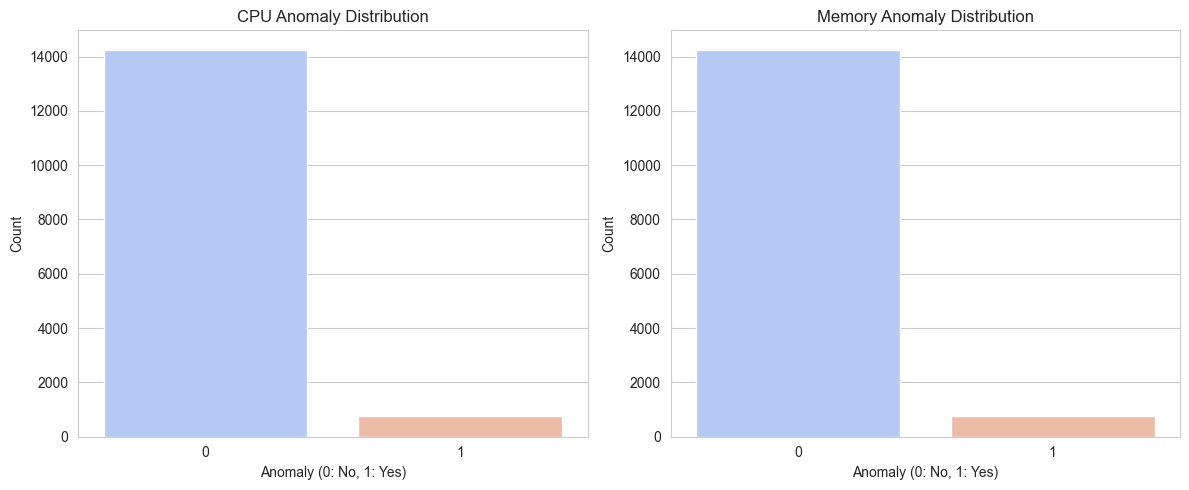

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Convert anomaly counts to DataFrame for Seaborn
cpu_anomaly_counts = df_processed['cpu_anomaly'].value_counts().reset_index()
cpu_anomaly_counts.columns = ['Anomaly', 'Count']

memory_anomaly_counts = df_processed['memory_anomaly'].value_counts().reset_index()
memory_anomaly_counts.columns = ['Anomaly', 'Count']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# CPU Anomaly Distribution
sns.barplot(data=cpu_anomaly_counts, x='Anomaly', y='Count', hue='Anomaly', palette="coolwarm", legend=False, ax=axes[0])
axes[0].set_title("CPU Anomaly Distribution")
axes[0].set_xlabel("Anomaly (0: No, 1: Yes)")
axes[0].set_ylabel("Count")

# Memory Anomaly Distribution
sns.barplot(data=memory_anomaly_counts, x='Anomaly', y='Count', hue='Anomaly', palette="coolwarm", legend=False, ax=axes[1])
axes[1].set_title("Memory Anomaly Distribution")
axes[1].set_xlabel("Anomaly (0: No, 1: Yes)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [30]:
import joblib

# Load the model
model = joblib.load("k8s_best_model_xgboost.pkl")

# Check the loaded model
print(model)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


In [31]:
import joblib

# Load the model
model = joblib.load("k8s_best_model_random_forest.pkl")

# Check the loaded model
print(model)


RandomForestClassifier(random_state=42)


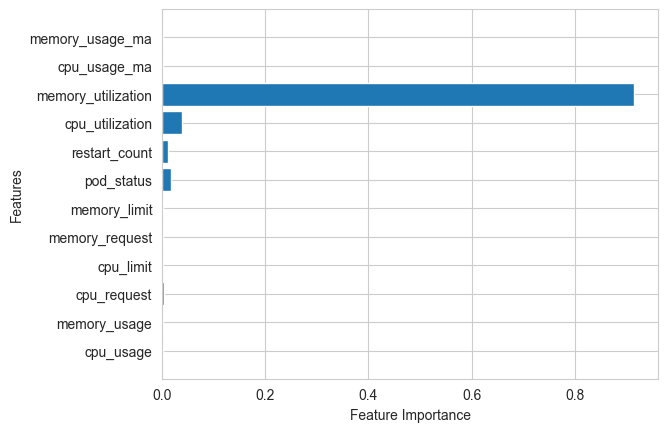

In [33]:
import matplotlib.pyplot as plt
feature_importances = best_xgb.feature_importances_
plt.barh(df_processed.drop(columns=target_cols).columns, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()
